# Mount gdrive

Mounting to gdrive to import model file

In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Changing directory to Session 2 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/06_BatchNorm_Regularization/

/content/gdrive/My Drive/TSAI-EVA-7.0/06_BatchNorm_Regularization



# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

# Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [ ]:
from model import Net

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_1 = 0.01

def train(model, device, train_loader, optimizer, epoch, regularization=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1 = 0.01
    if regularization:
      for p in model.parameters():
        l1 = l1 + p.abs().sum()

    loss = loss + lambda_1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
metrics = {}

In [ ]:
for n_type in ['BN', 'LN', 'GN']:

  print('Normalization type', n_type)

  model = Net(n_type).to(device)
  summary(model, input_size=(1, 28, 28))

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  # make all empty for each type of the normalization 
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  EPOCHS = 20
  
  for epoch in range(EPOCHS):

    print("EPOCH:", epoch)

    regularization = True if n_type == "BN" else False

    train(model, device, train_loader, optimizer, epoch, regularization)
    test(model, device, test_loader)

  n_type = n_type + '_L1' if n_type == 'BN' else n_type
  metrics[n_type] = [train_losses, test_losses, train_acc, test_acc]
  torch.save(model.state_dict(), './saved_models/'+n_type+'_model_weights.pth')

Normalization type BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 10, 24, 24]             720
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]           1,080
       BatchNorm2d-9           [-1, 12, 10, 10]              24
           Conv2d-10             [-1, 14, 8, 8]           1,512
             ReLU-11             [-1, 14, 8, 8]               0
      BatchNorm2d-12             [-1, 14, 8, 8]              28
           Conv2d-13             [-1, 16, 6, 6]           2,016
             ReLU

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.8327497243881226 Batch_id=468 Accuracy=87.66: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]



Test set: Average loss: 0.7665, Accuracy: 7533/10000 (75.33%)

EPOCH: 1


Loss=1.2774975299835205 Batch_id=468 Accuracy=92.86: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]



Test set: Average loss: 0.5044, Accuracy: 8693/10000 (86.93%)

EPOCH: 2


Loss=1.161421298980713 Batch_id=468 Accuracy=92.65: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s]



Test set: Average loss: 0.4680, Accuracy: 8881/10000 (88.81%)

EPOCH: 3


Loss=1.1333881616592407 Batch_id=468 Accuracy=92.64: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s]



Test set: Average loss: 0.6414, Accuracy: 8290/10000 (82.90%)

EPOCH: 4


Loss=1.231057047843933 Batch_id=468 Accuracy=92.69: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s]



Test set: Average loss: 0.6605, Accuracy: 7702/10000 (77.02%)

EPOCH: 5


Loss=1.1533111333847046 Batch_id=468 Accuracy=92.47: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]



Test set: Average loss: 0.7814, Accuracy: 7666/10000 (76.66%)

EPOCH: 6


Loss=1.2225184440612793 Batch_id=468 Accuracy=92.48: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]



Test set: Average loss: 0.3254, Accuracy: 9172/10000 (91.72%)

EPOCH: 7


Loss=1.1331571340560913 Batch_id=468 Accuracy=92.59: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]



Test set: Average loss: 0.4844, Accuracy: 8516/10000 (85.16%)

EPOCH: 8


Loss=1.0321494340896606 Batch_id=468 Accuracy=92.55: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]



Test set: Average loss: 0.5471, Accuracy: 8344/10000 (83.44%)

EPOCH: 9


Loss=1.2500483989715576 Batch_id=468 Accuracy=92.44: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]



Test set: Average loss: 0.3706, Accuracy: 8838/10000 (88.38%)

EPOCH: 10


Loss=1.1990665197372437 Batch_id=468 Accuracy=92.47: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]



Test set: Average loss: 0.3758, Accuracy: 8800/10000 (88.00%)

EPOCH: 11


Loss=0.9649372100830078 Batch_id=468 Accuracy=92.65: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]



Test set: Average loss: 0.7558, Accuracy: 7576/10000 (75.76%)

EPOCH: 12


Loss=1.1372723579406738 Batch_id=468 Accuracy=92.56: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]



Test set: Average loss: 0.3136, Accuracy: 9076/10000 (90.76%)

EPOCH: 13


Loss=1.0096073150634766 Batch_id=468 Accuracy=92.46: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]



Test set: Average loss: 0.7197, Accuracy: 7869/10000 (78.69%)

EPOCH: 14


Loss=1.0170866250991821 Batch_id=468 Accuracy=92.59: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]



Test set: Average loss: 0.4964, Accuracy: 8505/10000 (85.05%)

EPOCH: 15


Loss=1.0802249908447266 Batch_id=468 Accuracy=92.62: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]



Test set: Average loss: 0.9752, Accuracy: 6877/10000 (68.77%)

EPOCH: 16


Loss=1.177578091621399 Batch_id=468 Accuracy=92.58: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]



Test set: Average loss: 0.5276, Accuracy: 8398/10000 (83.98%)

EPOCH: 17


Loss=1.0185364484786987 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]



Test set: Average loss: 0.7791, Accuracy: 7615/10000 (76.15%)

EPOCH: 18


Loss=1.0823311805725098 Batch_id=468 Accuracy=92.71: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]



Test set: Average loss: 0.4166, Accuracy: 8810/10000 (88.10%)

EPOCH: 19


Loss=1.040265679359436 Batch_id=468 Accuracy=92.66: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]



Test set: Average loss: 0.7757, Accuracy: 7429/10000 (74.29%)

Normalization type LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         LayerNorm-3            [-1, 8, 26, 26]          10,816
            Conv2d-4           [-1, 10, 24, 24]             720
              ReLU-5           [-1, 10, 24, 24]               0
         LayerNorm-6           [-1, 10, 24, 24]          11,520
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]           1,080
         LayerNorm-9           [-1, 12, 10, 10]           2,400
           Conv2d-10             [-1, 14, 8, 8]           1,512
             ReLU-11             [-1, 14, 8, 8]               0
        LayerNorm-12             [-1, 14, 8, 8]           1,792
           Conv2d

Loss=0.09575182944536209 Batch_id=468 Accuracy=90.84: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]



Test set: Average loss: 0.0730, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.0877537950873375 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]



Test set: Average loss: 0.0579, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.029857737943530083 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]



Test set: Average loss: 0.0501, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.017433665692806244 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.0393, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.025671444833278656 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]



Test set: Average loss: 0.0432, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.037417929619550705 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]



Test set: Average loss: 0.0396, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.040942464023828506 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.02761957421898842 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]



Test set: Average loss: 0.0391, Accuracy: 9888/10000 (98.88%)

EPOCH: 8


Loss=0.06651175022125244 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 9


Loss=0.013234886340796947 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]



Test set: Average loss: 0.0294, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.027719436213374138 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]



Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.053960952907800674 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]



Test set: Average loss: 0.0265, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.003203872125595808 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]



Test set: Average loss: 0.0275, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.015124685131013393 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0243, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.008483081124722958 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]



Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.018588609993457794 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]



Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.015079325996339321 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.04516061767935753 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]



Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.0024677133187651634 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]



Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.006633739452809095 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]



Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

Normalization type GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 10, 24, 24]             720
              ReLU-5           [-1, 10, 24, 24]               0
         GroupNorm-6           [-1, 10, 24, 24]              20
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]           1,080
         GroupNorm-9           [-1, 12, 10, 10]              24
           Conv2d-10             [-1, 14, 8, 8]           1,512
             ReLU-11             [-1, 14, 8, 8]               0
        GroupNorm-12             [-1, 14, 8, 8]              28
           Conv2d

Loss=0.08398336917161942 Batch_id=468 Accuracy=88.71: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]



Test set: Average loss: 0.0940, Accuracy: 9745/10000 (97.45%)

EPOCH: 1


Loss=0.10085456073284149 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]



Test set: Average loss: 0.0664, Accuracy: 9822/10000 (98.22%)

EPOCH: 2


Loss=0.05928630009293556 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]



Test set: Average loss: 0.0512, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.09075464308261871 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]



Test set: Average loss: 0.0512, Accuracy: 9861/10000 (98.61%)

EPOCH: 4


Loss=0.01243523322045803 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]



Test set: Average loss: 0.0396, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.057770583778619766 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]



Test set: Average loss: 0.0409, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.06919413059949875 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]



Test set: Average loss: 0.0366, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.01481954101473093 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]



Test set: Average loss: 0.0350, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.013972443528473377 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0343, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.061343710869550705 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]



Test set: Average loss: 0.0336, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.006568171549588442 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]



Test set: Average loss: 0.0290, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.01880345493555069 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]



Test set: Average loss: 0.0295, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.004453855101019144 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0275, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.003449999261647463 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0299, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.004845709539949894 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]



Test set: Average loss: 0.0280, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.0043866876512765884 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]



Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.00458817882463336 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]



Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

EPOCH: 17


Loss=0.007862824946641922 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.15637513995170593 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.06823954731225967 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)



# Plotting metrics


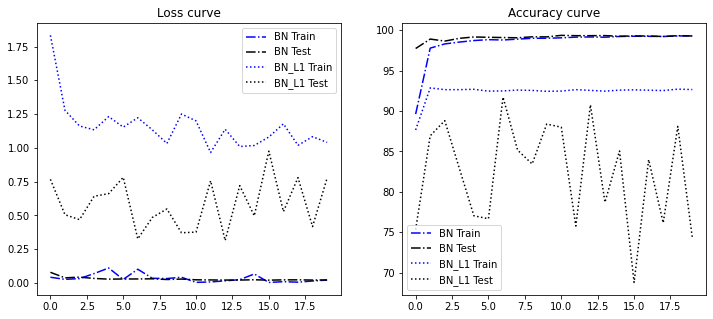

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
style = ['-.', ':']

for i, key in enumerate(['BN', 'BN_L1']):

  train_losses, test_losses, train_acc, test_acc = metrics[key]

  ax1.plot(train_losses, style[i], c='blue', label=key+' Train')
  ax1.plot(test_losses, style[i], c='black', label=key+' Test')

  ax2.plot(train_acc, style[i], c='blue', label=key+' Train')
  ax2.plot(test_acc, style[i], c='black', label=key+' Test')

ax1.title.set_text('Loss curve')
ax2.title.set_text('Accuracy curve')

ax1.legend()
ax2.legend()

plt.savefig('./plots/metrics_L1.png')

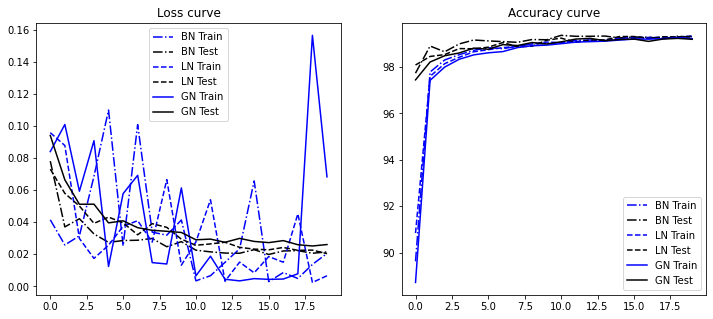

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
style = ['-.', '--', '-']

for i, key in enumerate(['BN', 'LN', 'GN']):

  train_losses, test_losses, train_acc, test_acc = metrics[key]

  ax1.plot(train_losses, style[i], c='blue', label=key+' Train')
  ax1.plot(test_losses, style[i], c='black', label=key+' Test')

  ax2.plot(train_acc, style[i], c='blue', label=key+' Train')
  ax2.plot(test_acc, style[i], c='black', label=key+' Test')

ax1.title.set_text('Loss curve')
ax2.title.set_text('Accuracy curve')

ax1.legend()
ax2.legend()

plt.savefig('./plots/metrics.png')

# Misclassified images

In [ ]:
def plot_misclassified(image, pred, target, image_path):

    nrows = 2
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 4))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].set_title("Prediction: %d\nTarget: %d" % (pred[index], target[index]))
            ax[i, j].imshow(image[index].cpu().numpy())

    if image_path is not None:
        fig.savefig(image_path)

Misclassified examples for  BN


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


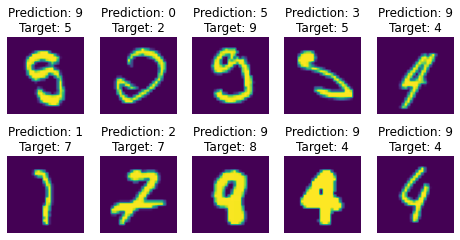



Misclassified examples for  BN_L1


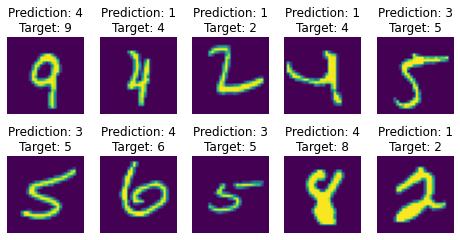



Misclassified examples for  LN


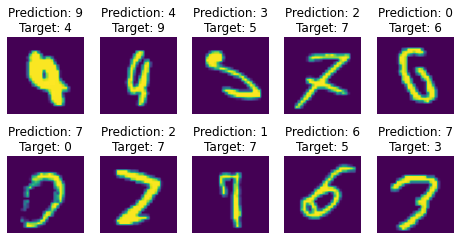



Misclassified examples for  GN


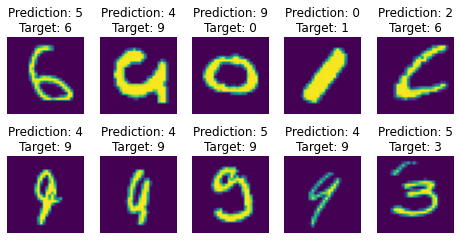

In [63]:
for i, key in enumerate(metrics.keys()):

  print('Misclassified examples for ', key)

  a = 'BN' if key == 'BN_L1' else key 
  model = Net(a).to(device)

  PATH = './saved_models/'+key+'_model_weights.pth'
  model.load_state_dict(torch.load(PATH))

  model.eval()
  misclassified_images, misclassified_predictions, true_targets = [], [], []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)

      index_ = (pred.eq(target.view_as(pred))==False)

      misclassified_images.append(data[index_])
      misclassified_predictions.append(pred[index_])
      true_targets.append(target.view_as(pred)[index_])

  misclassified_images = torch.cat(misclassified_images)
  misclassified_predictions = torch.cat(misclassified_predictions)
  true_targets = torch.cat(true_targets)

  plot_misclassified(misclassified_images, misclassified_predictions, true_targets, './plots/'+key+'_misclassified.png')
  plt.show()
  
  print()
  print()